# Klasteryzacja (Clustering)

W tym laboratorium pracujemy na danych MNIST i badamy:
- dobór liczby klastrów dla KMeans (k = 8..12) z oceną silhouette score,
- zgodność klasteryzacji (k=10) z etykietami odniesienia poprzez macierz błędów,
- dobór parametru eps dla DBSCAN z wykorzystaniem heurystyki opartej o odległości euklidesowe,
- eksperyment z różnymi wartościami eps i analizę liczby wykrytych klastrów.

Zgodnie z poleceniem zapisujemy pliki wynikowe:
- kmeans_sil.pkl, kmeans_argmax.pkl,
- dist.pkl, dbscan_len.pkl.

Notebook ma układ i styl spójny z poprzednimi notatnikami (krótkie wprowadzenie + sekcje z kodem).


In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pickle


## Przygotowanie danych

In [2]:
# Pobranie zbioru MNIST (784 cechy na obserwację)
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.target = mnist.target.astype(np.uint8)

X = mnist['data']
y = mnist['target']

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (70000, 784), y shape: (70000,)


## KMeans: dobór liczby klastrów i silhouette score (k=8..12)

k=8: silhouette=0.07339
k=9: silhouette=0.05673
k=10: silhouette=0.05869
k=11: silhouette=0.05836
k=12: silhouette=0.05818


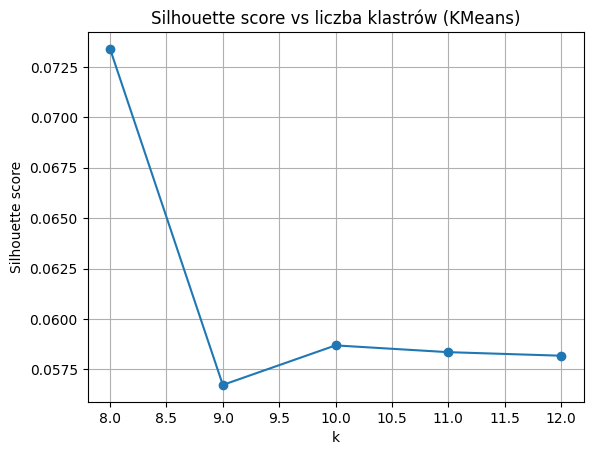

In [3]:
k_to_sil = {}

# Dla k = 8..12 trenujemy KMeans (n_init=10) i zapisujemy silhouette score
for k in range(8, 13):
    km = KMeans(n_clusters=k, n_init=10)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    k_to_sil[k] = sil
    print(f"k={k}: silhouette={sil:.5f}")

# Wizualizacja
plt.plot(list(k_to_sil.keys()), list(k_to_sil.values()), marker='o')
plt.title("Silhouette score vs liczba klastrów (KMeans)")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

# Zapis do Pickle (lista wartości zgodnie z zakresem k=8..12)
sil_list = [k_to_sil[k] for k in range(8, 13)]
with open('kmeans_sil.pkl', 'wb') as f:
    pickle.dump(sil_list, f)


## Macierz błędów dla KMeans (k=10) vs etykiety odniesienia

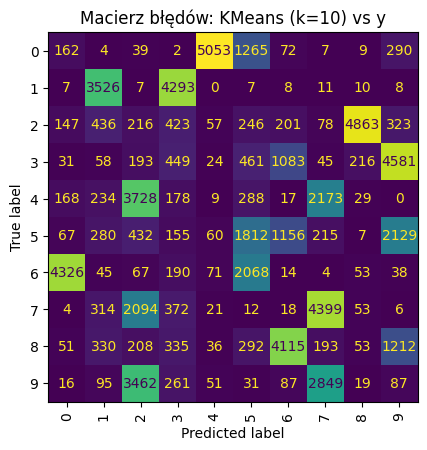

Unikalne indeksy kolumn (posortowane): [0, 2, 3, 4, 6, 7, 8, 9]


In [4]:
# Klasteryzacja dla k=10 i porównanie z y (etykiety referencyjne)
km_10 = KMeans(n_clusters=10, n_init=10)
y_pred = km_10.fit_predict(X)

cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(xticks_rotation='vertical', colorbar=False)
plt.title("Macierz błędów: KMeans (k=10) vs y")
plt.show()

# Dla każdego wiersza bierzemy indeks kolumny o największej wartości
max_indexes = [int(np.argmax(row)) for row in cm]
unique_sorted = sorted(set(max_indexes))
print("Unikalne indeksy kolumn (posortowane):", unique_sorted)

with open('kmeans_argmax.pkl', 'wb') as f:
    pickle.dump(unique_sorted, f)


## DBSCAN: heurystyka doboru eps na podstawie odległości

In [5]:
# Heurystyka eps:
# Liczymy odległości euklidesowe między pierwszymi 300 punktami a wszystkimi innymi.
X_first = X[:300]
all_dists = []

for i in range(X_first.shape[0]):
    d = np.linalg.norm(X - X_first[i], axis=1)
    d = d[d != 0]  # pomijamy dokładną odległość 0 do samego siebie
    all_dists.append(d)

all_dists = np.concatenate(all_dists)
top_10 = np.sort(all_dists)[:10]
print("10 najmniejszych odległości:", top_10)

with open('dist.pkl', 'wb') as f:
    pickle.dump(top_10, f)

# Średnia s z 3 najmniejszych wartości
s = float(np.mean(top_10[:3]))
print("s (średnia z 3 najmniejszych):", s)

# eps od s do s + 10%*s z krokiem co 4%*s
eps_list = []
eps = s
while eps < s + 0.10 * s + 1e-12:  # mały margines numeryczny
    eps_list.append(eps)
    eps += 0.04 * s
print("Testowane eps:", eps_list)


10 najmniejszych odległości: [279.26152617 304.3764117  317.5893575  328.76587414 333.45464459
 352.89800226 355.17742045 358.0740147  359.64287842 360.42474943]
s (średnia z 3 najmniejszych): 300.40909845916684
Testowane eps: [300.40909845916684, 312.4254623975335, 324.4418263359002]


## DBSCAN: eksperyment — liczba klastrów dla różnych eps

In [6]:
unique_labels_counts = []
for eps in eps_list:
    db = DBSCAN(eps=eps)
    db.fit(X)
    n_unique = len(np.unique(db.labels_))
    unique_labels_counts.append(n_unique)
    print(f"eps={eps:.6f} -> liczba unikalnych etykiet: {n_unique}")

with open('dbscan_len.pkl', 'wb') as f:
    pickle.dump(unique_labels_counts, f)


eps=300.409098 -> liczba unikalnych etykiet: 4
eps=312.425462 -> liczba unikalnych etykiet: 7
eps=324.441826 -> liczba unikalnych etykiet: 22


## Podsumowanie

W tym laboratorium przeanalizowano metody klasteryzacji na zbiorze MNIST. Porównano wyniki KMeans dla różnych liczby klastrów oraz ocenę jakości podziału za pomocą silhouette score i macierzy błędów. Przetestowano także algorytm DBSCAN z różnymi parametrami eps, pokazując wpływ tego parametru na liczbę wykrytych klastrów. Odpowiedni dobór metody i parametrów pozwala lepiej dopasować model do struktury danych.